In [1]:
from Utils.preprocessing import *
from Utils.customPipelines import *

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score

import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

sns.set(style='ticks')

RANDOM_STATE = 632

In [2]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("Data//jobs_in_data.csv")
sample_data_b = pd.read_csv("Data//QF632_Project_2_b.csv")
sample_data_c = pd.read_csv("Data//QF632_Project_2_c.csv")
sample_data_d = pd.read_csv("Data//Glassdoor_Salary_Cleaned_Version.csv")

# Standardising the data

In [3]:
sample_data_comb = pd.concat([sample_data_a, sample_data_b, sample_data_c])
        
sample_data_comb = sample_data_comb.drop(columns=["salary_currency", "salary", "employee_residence"])

sample_data_comb["experience_level"] = np.where(sample_data_comb["experience_level"].str.contains("Mid"), "Mid", sample_data_comb["experience_level"])
sample_data_comb["experience_level"] = np.where(sample_data_comb["experience_level"].str.contains("Senior"), "Senior", sample_data_comb["experience_level"])
sample_data_comb["experience_level"] = np.where((sample_data_comb["experience_level"].str.contains("Entry") | (sample_data_comb["experience_level"].str.contains("Executive"))), "Entry", sample_data_comb["experience_level"])

sample_data_comb["experience_level"] = np.where(sample_data_comb["experience_level"] == "MI", "Mid", sample_data_comb["experience_level"])
sample_data_comb["experience_level"] = np.where(sample_data_comb["experience_level"] == "SE", "Senior", sample_data_comb["experience_level"])
sample_data_comb["experience_level"] = np.where((sample_data_comb["experience_level"] == "EN") | (sample_data_comb["experience_level"] == "EX"), "Entry", sample_data_comb["experience_level"])

sample_data_comb["company_size"] = np.where(sample_data_comb["company_size"] == "Large", "L", sample_data_comb["company_size"])
sample_data_comb["company_size"] = np.where(sample_data_comb["company_size"] == "Medium", "M", sample_data_comb["company_size"])
sample_data_comb["company_size"] = np.where(sample_data_comb["company_size"] == "Small", "S", sample_data_comb["company_size"])

sample_data_comb["job_category"] = sample_data_comb["job_category"].apply(lambda x: x.lower() if type(x) == str else x)
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "data science and research", "data scientist", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "data engineering", "data engineer", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "data architecture and modeling", "data architect", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "machine learning and ai", "machine learning", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "data analysis", "data analyst", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "bi and visualization", "data insights", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "bi and visualization", "data insights", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "data management and strategy", "data management", sample_data_comb["job_category"])
sample_data_comb["job_category"] = np.where(sample_data_comb["job_category"] == "leadership and management", np.nan, sample_data_comb["job_category"])

roles = {"data scientist": ["scientist", "science", "statistics"], 
         "data analyst":["analyst", "analysis"],
         "data insights":["bi", "visual"],
         "machine learning":["ml", "machine", "ai"],
         "research scientist":["research"],
         "data architect":["architect"],
         "data engineer":["engineer"],
         "data product":["product"],
         "cloud and database":["cloud"],
         "data management":["data", "database"],
         }

for ind in range(len(sample_data_comb)):
    row = sample_data_comb.iloc[ind]
    if type(row["job_category"]) != str:
        job = row["job_title"]
        for role in roles:
            if any(sub.lower() in roles[role] for sub in job.split(" ")):
                sample_data_comb.iloc[ind, 2] = role
                break

sample_data_comb = sample_data_comb.rename(columns={"salary_in_usd": "y", "job_category": "TYPE", "work_year": "YEAR", "job_title": "JOB TITLE", 
                                            "experience_level": "EXP", "company_location": "LOCATION", "company_size": "EMPLOYER_SIZE"})

print(sample_data_comb.shape)
sample_data_comb.sample(7)

(26624, 11)


,YEAR,JOB TITLE,TYPE,y,EXP,employment_type,work_setting,LOCATION,EMPLOYER_SIZE,remote_ratio,work_models
7342,2023,Data Engineer,data engineer,70000,Mid,Full-time,In-person,United States,M,NaN,NaN
99,2024,Data Engineer,data engineer,118300,Senior,FT,NaN,US,M,0.0,NaN
338,2023,Machine Learning Engineer,machine learning,305600,Senior,Full-time,In-person,United States,M,NaN,NaN
3852,2023,Data Strategist,data management,73500,Mid,FT,NaN,US,M,0.0,NaN
5388,2022,Data Scientist,data scientist,180000,Mid,Full-time,NaN,United States,M,NaN,On-site
5114,2023,Data Engineer,data engineer,125000,Senior,Full-time,NaN,Canada,M,NaN,On-site
4520,2023,Data Engineer,data engineer,60000,Mid,Full-time,NaN,Mexico,M,NaN,Remote


In [12]:
sample_data_d_temp = sample_data_d.copy()

sample_data_d_temp["company_txt"] = sample_data_d_temp["company_txt"].apply(lambda x: x.upper() if type(x) == str else x)
sample_data_d_temp["company_txt"] = sample_data_d_temp["company_txt"].str.slice(0, -2)

sample_data_d_temp = sample_data_d_temp.rename(columns={"Job Title": "JOB TITLE", "avg_salary": "y", "company_txt": "EMPLOYER", "Location": "LOCATION", "job_state": "STATE"})

sample_data_d_temp["EMPLOYER_SIZE"] = "L"
sample_data_d_temp["EMPLOYER_SIZE"] = np.where((sample_data_d_temp["Size"] == "1 to 50 employees") | (sample_data_d_temp["Size"] == "51 to 200 employees"), 
                                              "M", sample_data_d_temp["EMPLOYER_SIZE"])
sample_data_d_temp["EMPLOYER_SIZE"] = np.where((sample_data_d_temp["Size"] == "501 to 1000 employees") | (sample_data_d_temp["Size"] == "201 to 500 employees"), 
                                              "M", sample_data_d_temp["EMPLOYER_SIZE"])
sample_data_d_temp["EMPLOYER_SIZE"] = np.where((sample_data_d_temp["Size"] == "Unknown") | (sample_data_d_temp["Size"] == "-1"), 
                                              np.nan, sample_data_d_temp["EMPLOYER_SIZE"])

job_categories = []
for ind in range(len(sample_data_d_temp)):
    row = sample_data_d_temp.iloc[ind]
    job = row["JOB TITLE"]
    role_not_found = True
    for role in roles:
        if any(sub.lower() in roles[role] for sub in job.split(" ")):
            job_categories.append(role)
            role_not_found = False
            break
    if role_not_found:
        job_categories.append(np.nan)

sample_data_d_temp["TYPE"] = job_categories

exp = {"Mid":["II", "2", "&", "SPECIALIST", "ADVANCED", "LEAD", "MID"], "Senior":["III", "3", "SR", "SNR", "SENIOR", "PROFESSOR", "MANAGE", "MANAGER", "MANAGEMENT", "MGR", "PHD", "DIRECTOR", "IV", "V", "4", "5", "LEADER", "HEAD"]}
exp_level = []

for job in sample_data_d_temp["JOB TITLE"]:
    if any(sub in exp["Senior"] for sub in job.split(" ")):
        exp_level.append("Senior")
    elif any(sub in exp["Mid"] for sub in job.split(" ")):
        exp_level.append("Mid")
    else:
        exp_level.append("Entry")

sample_data_d_temp["EXP"] = exp_level


sample_data_d_temp = sample_data_d_temp.drop(columns=["Salary Estimate", "Job Description", "Rating", "Headquarters", "Founded", "Type of ownership", "Industry", "Sector", "Company Name", "Size",
                                                      'Revenue', 'Competitors', 'hourly', 'min_salary', 'max_salary', 'same_state', 'age', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', "employer_provided"])

print(sample_data_d_temp.shape)
sample_data_d_temp.sample(7)

(742, 8)


,JOB TITLE,LOCATION,y,EMPLOYER,STATE,EMPLOYER_SIZE,TYPE,EXP
421,Senior Scientist - Biostatistician,"Winston-Salem, NC",80.5,REYNOLDS AMERICAN,NC,L,data scientist,Entry
309,Data Engineer,"Springfield, MA",92.0,MASSMUTUAL,MA,L,data engineer,Entry
588,Salesforce Analytics Consultant,"Chicago, IL",66.5,"EMTEC, INC.",IL,M,NaN,Entry
727,Revenue Analytics Manager,"San Francisco, CA",61.5,HOVER,CA,M,NaN,Entry
23,Data Scientist,"Louisville, KY",84.0,SMC 3,KY,M,data scientist,Entry
483,Data Scientist,"New York, NY",75.5,EXECONLINE,NY,M,data scientist,Entry
337,Medical Laboratory Scientist,"Burleson, TX",21.5,TEXAS HEALTH HUGULEY HOSPITAL,TX,L,data scientist,Entry


In [5]:
sample_data_comb2 = pd.concat([sample_data_comb, sample_data_d_temp])

print(sample_data_comb2.shape)
sample_data_comb2.sample(7)

(27366, 13)


,YEAR,JOB TITLE,TYPE,y,EXP,employment_type,work_setting,LOCATION,EMPLOYER_SIZE,remote_ratio,work_models,EMPLOYER,STATE
7526,2022.0,AI Programmer,machine learning,40000.0,Entry,Full-time,Remote,Australia,M,NaN,NaN,NaN,NaN
5591,2023.0,Machine Learning Scientist,machine learning,138000.0,Senior,Full-time,Remote,United States,M,NaN,NaN,NaN,NaN
21,NaN,Senior Data Scientist / Machine Learning,data scientist,96.0,NaN,NaN,NaN,"Dallas, TX",M,NaN,NaN,HEALTH IQ,TX
3322,2023.0,Data Engineer,data engineer,140100.0,Senior,Full-time,NaN,United States,M,NaN,On-site,NaN,NaN
4012,2023.0,Business Intelligence Analyst,data insights,124400.0,Senior,Full-time,Remote,United States,M,NaN,NaN,NaN,NaN
9349,2021.0,Data Engineer,data engineer,28369.0,Mid,Full-time,Hybrid,Malta,L,NaN,NaN,NaN,NaN
2155,2023.0,Analytics Engineer,data engineer,169900.0,Senior,FT,NaN,US,M,100.0,NaN,NaN,NaN


# Webscraping Portion

In [6]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    try: 
        dfs_base = pd.read_html(url)
    except: 
        continue
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    
    try:
        dfs_var = pd.read_html(url)
    except:
        continue
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(77391, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,Unnamed: 6,TYPE
2473,TYSON FOODS INC,DATA ENGINEER,76856,"SPRINGDALE, AR",06/09/2022,10/01/2022,NaN,data engineer
1267,CAPGEMINI AMERICA INC,DATA ANALYST 3,100400,"RARITAN, NJ",03/10/2018,09/09/2018,NaN,data analyst
2551,AMAZONCOM SERVICES LLC,DATA SCIENTIST I,165000,"SUNNYVALE,, CA",01/31/2022,02/05/2022,NaN,data scientist
5765,UNITED SERVICES AUTOMOBILE ASSOCIATION,DATA ENGINEER SENIOR,125000,"SAN ANTONIO, TX",09/20/2021,10/15/2021,NaN,data engineer
1478,ALPHONSO INC,DATA SCIENTIST,70803,"MOUNTAIN VIEW, CA",06/01/2022,10/01/2022,NaN,data scientist


# Data Cleaning


In [76]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.drop(columns=["Unnamed: 6"]).reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})

# Get employer size
all_df2["EMPLOYER_SIZE"] = "L"

# get cumulative no. of hires each year
years = all_df2["YEAR"].unique()
for year in years:
    df_temp = all_df2[all_df2["YEAR"] <= year].copy()
    df_temp = df_temp[["EMPLOYER", "y"]].groupby(["EMPLOYER"], as_index = False).size()
    mid = np.quantile(df_temp["size"], 0.95)
    all_M = list(df_temp[df_temp["size"] < mid]["EMPLOYER"])
    all_df2['EMPLOYER_SIZE'].mask(((all_df2["YEAR"] == year) & (all_df2["EMPLOYER"].isin(all_M))),'M', inplace=True)

    lower_quantile = np.quantile(df_temp["size"], 0.55)
    all_S = list(df_temp[df_temp["size"] < lower_quantile]["EMPLOYER"])
    all_df2['EMPLOYER_SIZE'].mask(((all_df2["YEAR"] == year) & (all_df2["EMPLOYER"].isin(all_S))),'S', inplace=True)


print(all_df2.shape)
all_df2.sample(7)

(71483, 10)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE,EMPLOYER_SIZE
19685,YUM CONNECT LLC,DATA SCIENTIST II,130000,"LOS ANGELES, CA",2021-09-23,2021-10-04,data scientist,2021,CA,M
8416,RADIUSAI INC,DATA SCIENTIST,115000,"TEMPE, AZ",2022-05-05,2022-10-01,data scientist,2022,AZ,M
15795,META PLATFORMS INC,DATA SCIENTIST,190120,"BELLEVUE, WA",2023-09-29,2024-03-29,data scientist,2024,WA,L
16046,D1 CAPITAL PARTNERS LP,DATA SCIENTIST,200000,"NEW YORK, NY",2020-06-01,2020-06-15,data scientist,2020,NY,S
8034,HEARST MAGAZINE MEDIA INC,DATA SCIENTIST,112112,"HARRISON, NJ",2022-03-17,2022-07-29,data scientist,2022,NJ,M
12896,GOOGLE LLC,DATA SCIENTIST,148000,"REDWOOD CITY, CA",2019-11-04,2019-11-11,data scientist,2019,CA,L
28713,MITEK SYSTEMS INC,DATA ANALYST,94827,"SAN DIEGO, CA",2023-04-18,2023-05-01,data analyst,2023,CA,M


I or II after a job title can indicate levels of exp, typically having II > I and so forth.

In [77]:
category = "JOB TITLE"

# Let's try to segregate by level of exp
exp_level = []

for job in all_df2["JOB TITLE"]:
    if any(sub in exp["Senior"] for sub in job.split(" ")):
        exp_level.append("Senior")
    elif any(sub in exp["Mid"] for sub in job.split(" ")):
        exp_level.append("Mid")
    else:
        exp_level.append("Entry")

all_df2["EXP"] = exp_level

In [79]:
data_comb = pd.concat([sample_data_comb2, all_df2])
data_comb["y"] =  pd.to_numeric(data_comb["y"]) / 1000

print(data_comb.shape)
data_comb.sample(7)

(98849, 15)


,YEAR,JOB TITLE,TYPE,y,EXP,employment_type,work_setting,LOCATION,EMPLOYER_SIZE,remote_ratio,work_models,EMPLOYER,STATE,SUBMIT DATE,START DATE
49291,2024.0,RESEARCH SCIENTIST II,research scientist,159.800,Mid,NaN,NaN,"SUNNYVALE, CA",L,NaN,NaN,AMAZONCOM SERVICES LLC,CA,2024-01-30,2024-07-28
7640,2023.0,Data Manager,data management,65.000,Senior,FT,NaN,CO,M,0.0,NaN,NaN,NaN,NaT,NaT
68807,2022.0,DATA ENGINEER II,data engineer,154.800,Mid,NaN,NaN,"AUSTIN, TX",L,NaN,NaN,AMAZONCOM SERVICES LLC,TX,2022-08-22,2022-08-26
53574,2019.0,DATA ENGINEER,data engineer,74.984,Entry,NaN,NaN,"SEATTLE, WA",L,NaN,NaN,SUPERLOGIX INC,WA,2019-09-17,2019-09-17
6723,2023.0,Data Scientist,data scientist,206.000,Senior,FT,NaN,US,M,0.0,NaN,NaN,NaN,NaT,NaT
34121,2018.0,MACHINE LEARNING ENGINEER,machine learning,73.885,Entry,NaN,NaN,"LOS ANGELES, CA",M,NaN,NaN,FRENZY LABS INC,CA,2018-03-28,2018-08-15
37827,2021.0,MACHINE LEARNING INFRASTRUCTURE ENGINEER,machine learning,175.000,Entry,NaN,NaN,"REDWOOD CITY, CA",S,NaN,NaN,TRUERA INC,CA,2021-11-09,2021-11-22


Entry     62210
Senior    22662
Mid       13235
Name: EXP, dtype: int64


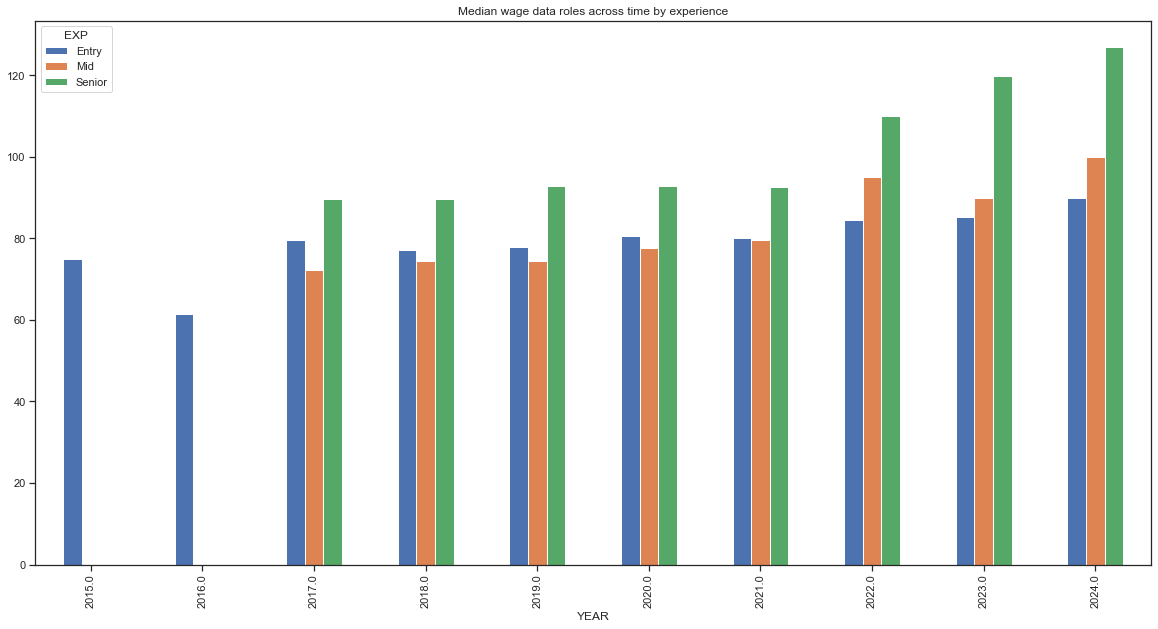

In [80]:
category = "EXP"
cat = "data analyst"

df_plt = data_comb[data_comb["TYPE"] == cat][["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).median().copy()
print(data_comb[category].value_counts())
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wage data roles across time by experience")

Entry     62210
Senior    22662
Mid       13235
Name: EXP, dtype: int64


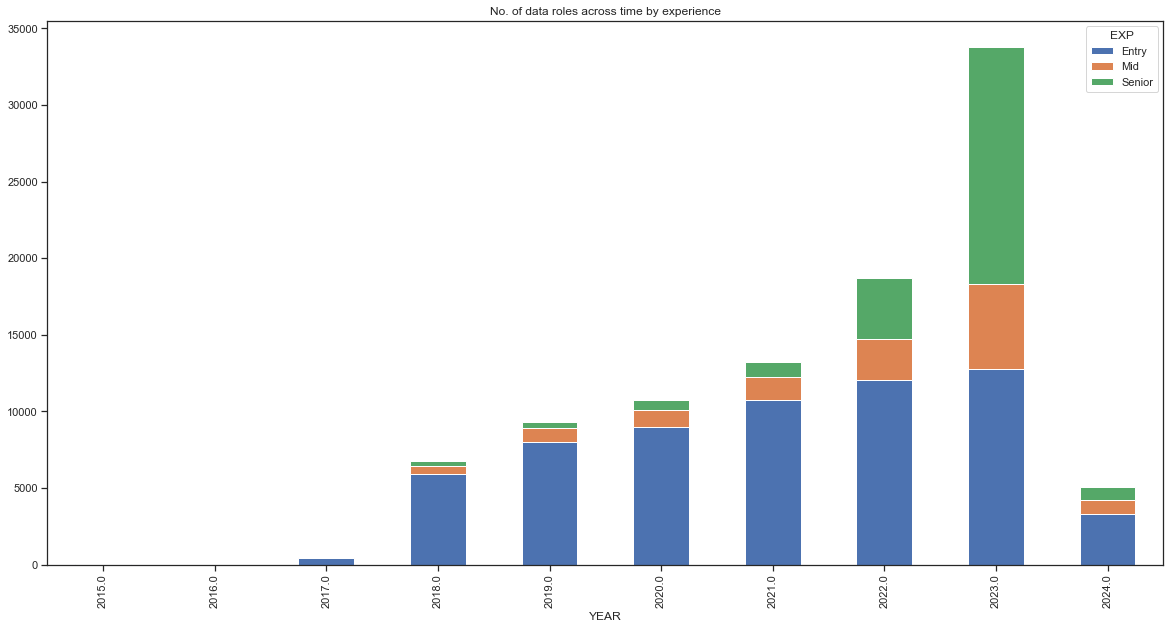

In [81]:
category = "EXP"

df_plt = data_comb[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
print(data_comb[category].value_counts())
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="No. of data roles across time by experience")

# Data Analysis

## 1. Numerical Features

## 2. Categorical features

### 2a. Analysis of job demand by job function

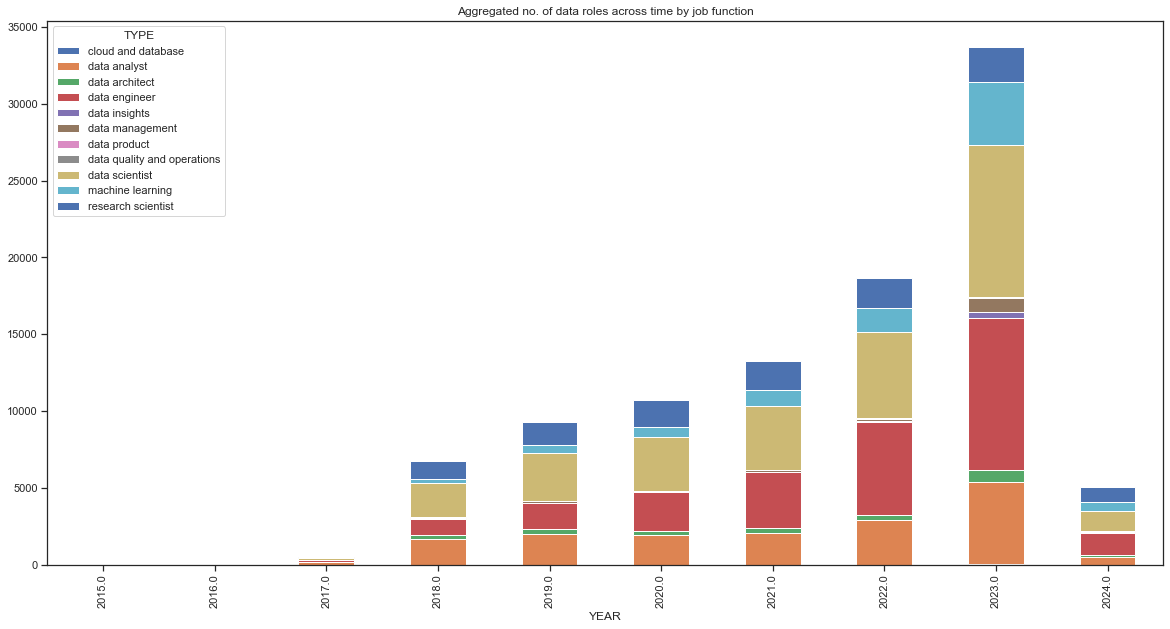

In [82]:
category = "TYPE"

df_plt = data_comb[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by job function")

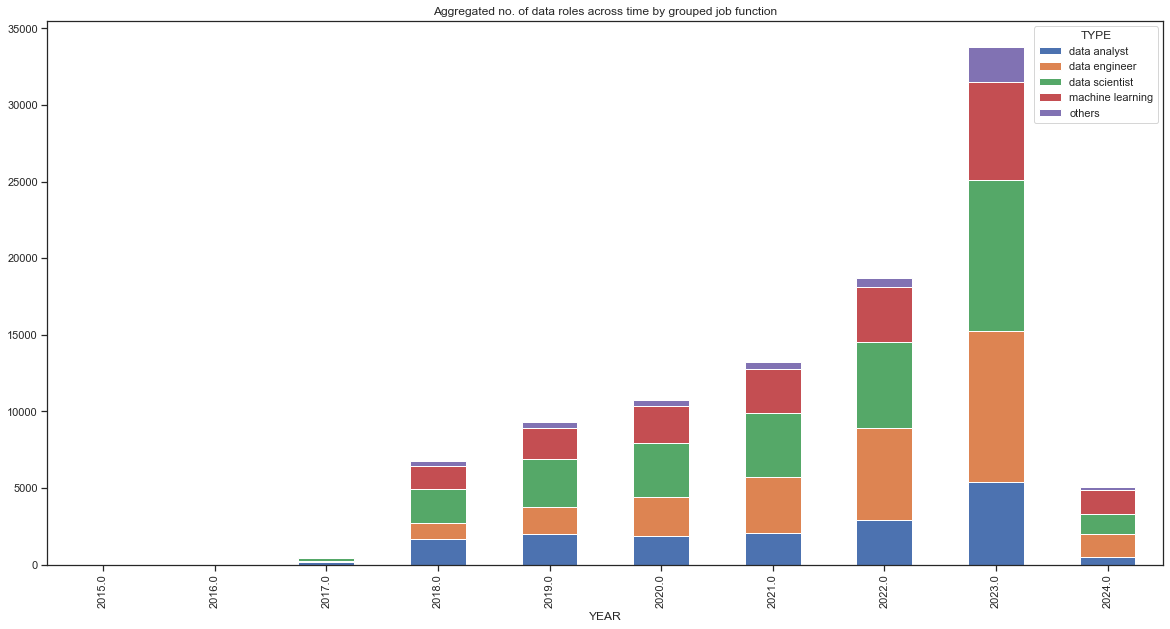

In [83]:
core_cat = ["data scientist", "data engineer", "data analyst", "machine learning"]

df_type_agg = data_comb.copy()
df_type_agg['TYPE'] = np.where(df_type_agg['TYPE']=="research scientist", "machine learning", df_type_agg['TYPE'])
df_type_agg['TYPE'].mask(~df_type_agg["TYPE"].isin(core_cat),'others', inplace=True)

df_plt = df_type_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by grouped job function")

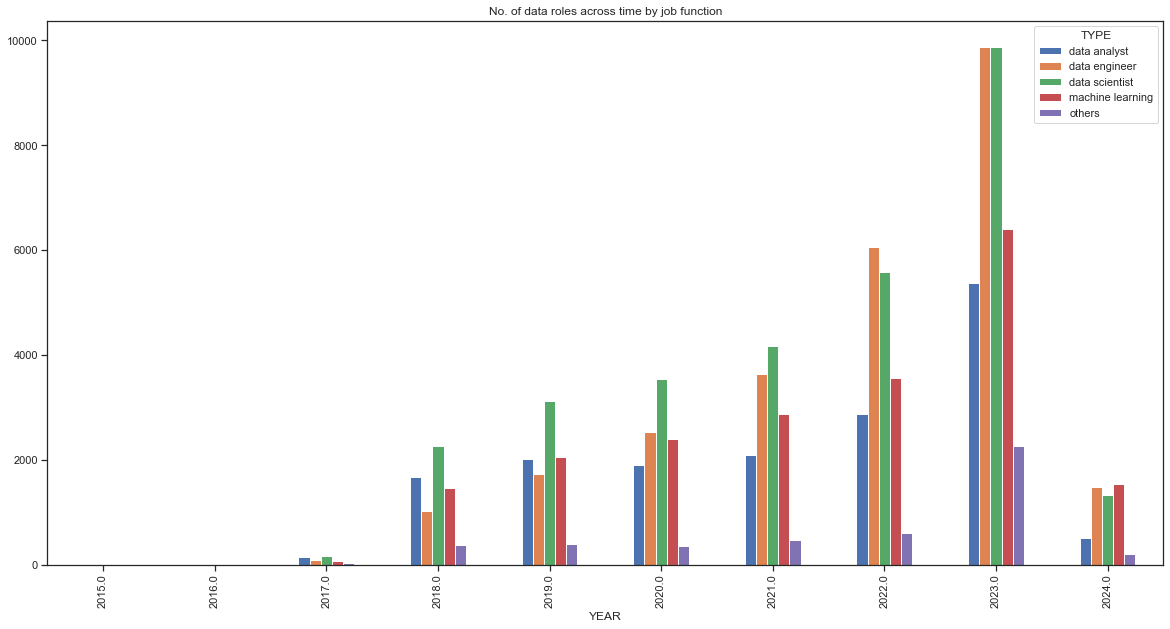

In [84]:
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by job function")

Job functions not of major classes (data analyst, data engineer, data scientist, research scientist) can form 1 class called "others".
From the graphs above, we can see that the number of data roles have been increasing across time, peaking in 2022. Further breakdown of the data roles into the major classes shows that demand for data engineers have seen the most growth across time, and remains to be of the highest demand today. Data scientists and research scientists have also seen a general increase in demand, while data analysts have seen fluctuations in demand across years.

### 2b. Analysis of wage by job function

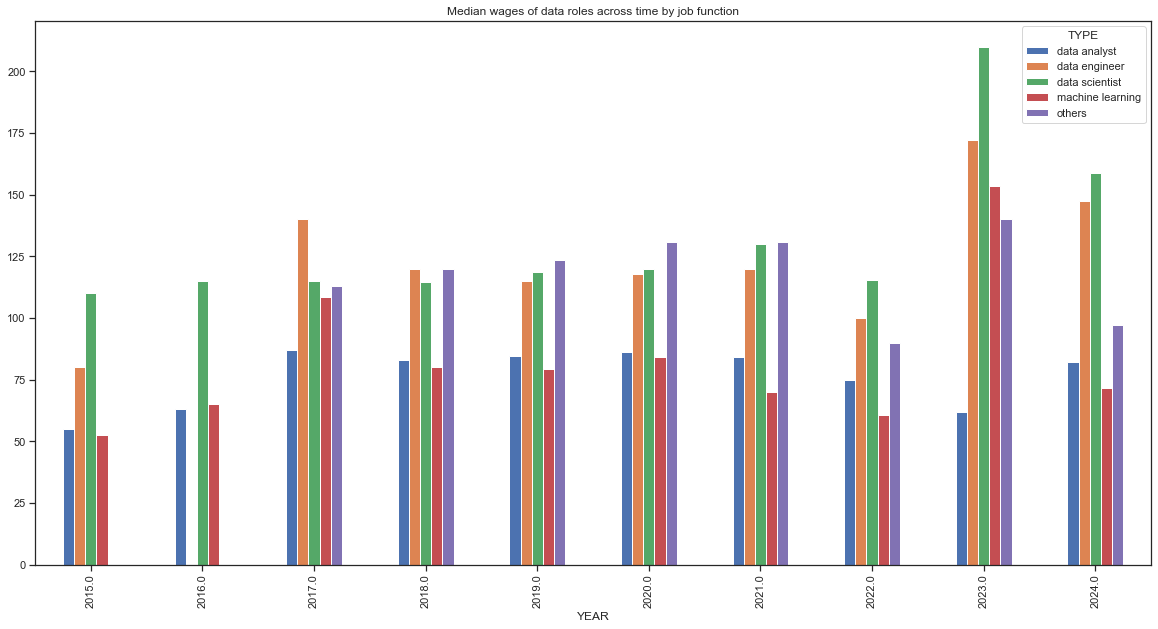

In [85]:
# get median wage of each job role for each year
df_plt = df_type_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by job function")

Generally, the median wages of all job functions have increased over time. As of 2024, data scientists have the highest median wage, followed by other functions, then data analysts, research scientists and data engineers. Compared to all other job functions, data scientists and data analysts have seen the largest increase in median wages from 2023 to 2024.

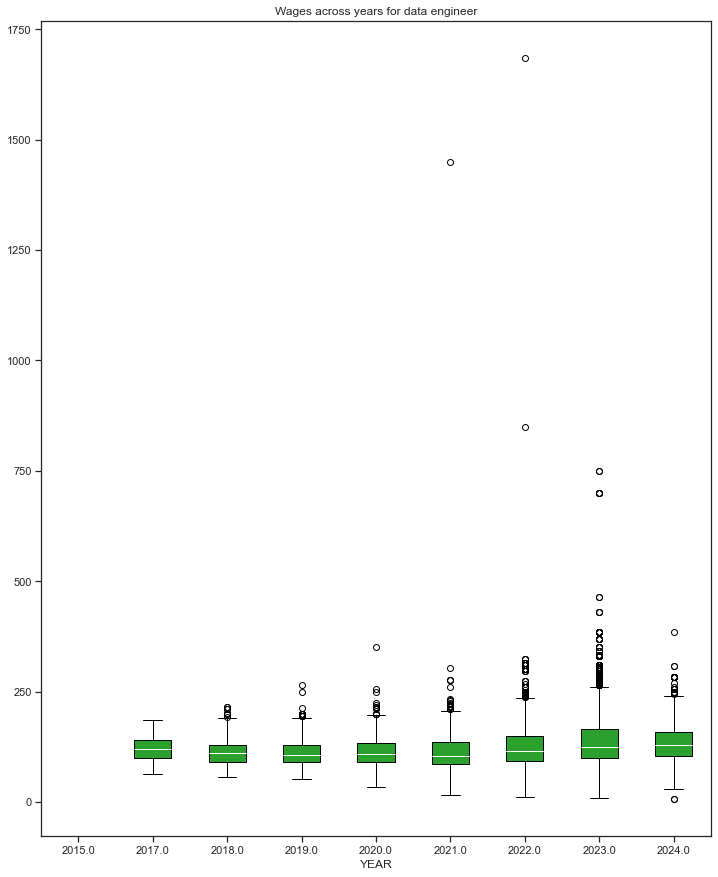

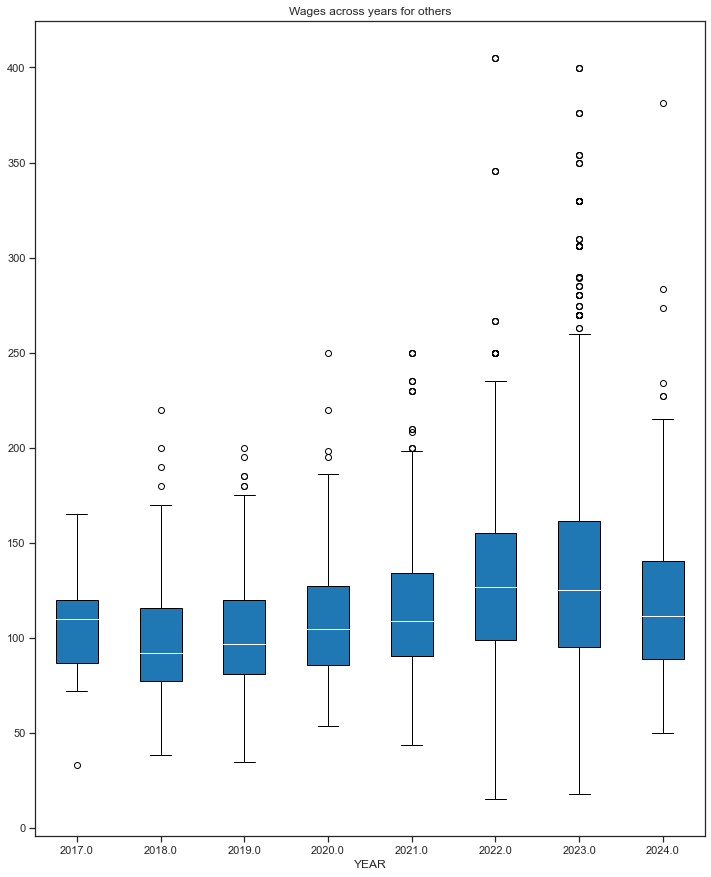

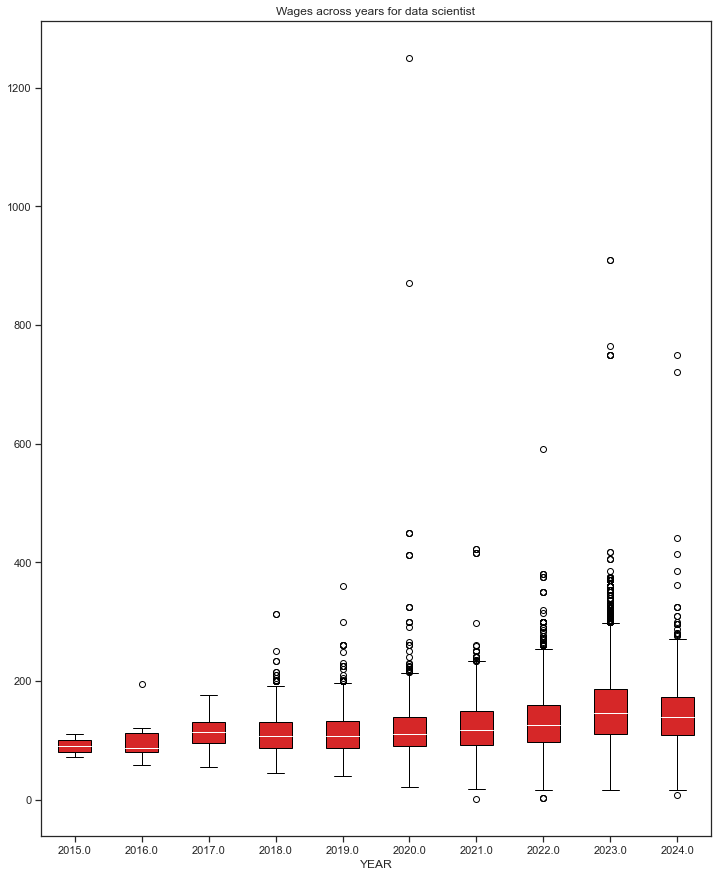

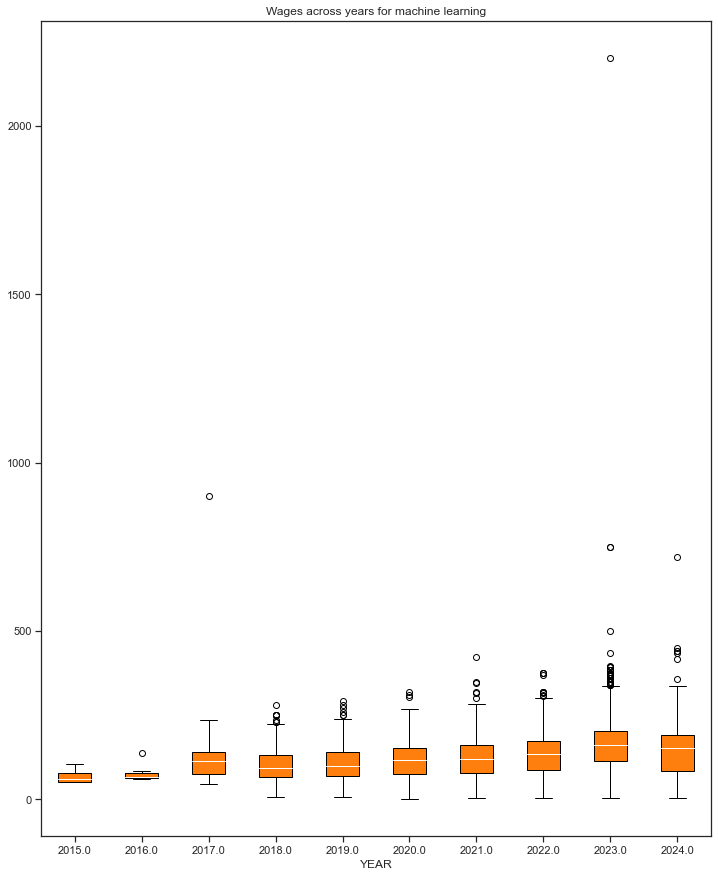

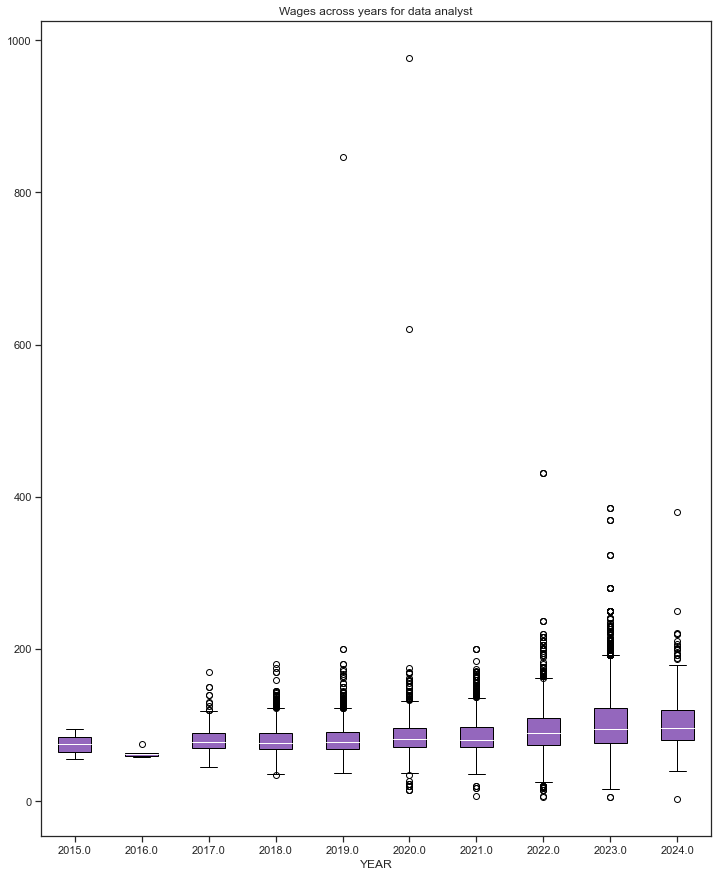

In [86]:
df_plt = df_type_agg[["YEAR", category, "y"]]

colors = ['#2ca02c','#1f77b4','#d62728','#ff7f0e','#9467bd']
for job_function, color in zip(df_plt[category].unique(), colors):
    df_filtered = df_plt[df_plt[category] == job_function]
    df_year = df_filtered.groupby('YEAR')['y'].apply(list)

    fig, ax = plt.subplots(figsize=(12, 15))
    box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,
                     boxprops=dict(facecolor=color),
                     medianprops=dict(color='white'))
    ax.set_title(f'Wages across years for {job_function}')
    ax.set_xlabel('YEAR')
#    ax.set_ylabel('y')
    plt.show()

For data scientists, median wages have decreased significantly since 2014 and have increased minimally since. The distribution of wages have also widened, with the wage discrepancy between the 75th and 25th percentile is the largest this year.


For data analysts, median wages have fluctuated minimally across years, except for a sudden increase in 2024. While the distribution of wages widened significantly in 2024, the lowest wage has also increased significantly compared to 2023.

For others, both the median wage and the wage distribution have generally increased over the years.

For research scientists, while median wage has fluctuated, the wage distribution has significantly widened over the years, and with positive wage outliers generally outearning more than 1.5x of the median wage. Currently in 2024, the median wage skews negative of the general wage distribution. 

For data engineers, the median wage has fluctuated over the years, and wage distribution has also increased minimally. 2024 saw the largest increase in median wage.

### 2c. Analysis of job demand by state

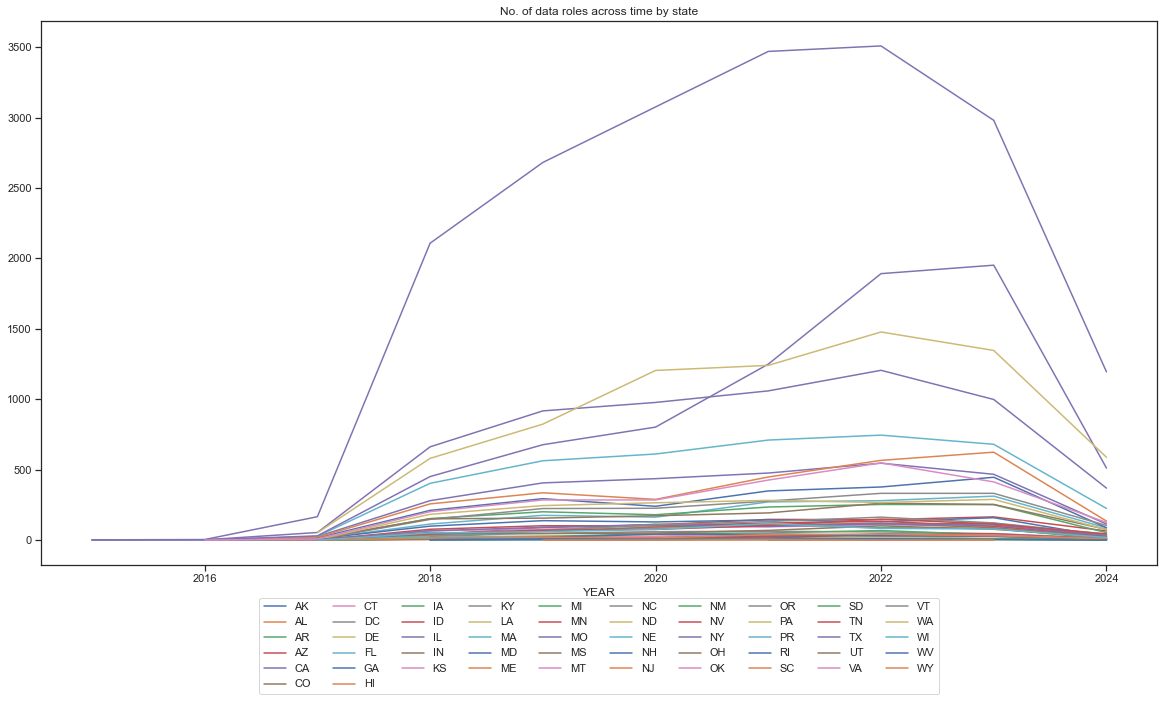

In [87]:
category = "STATE"

df_plt = data_comb[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

Across states, the number of data roles have been increasing across time, peaking in 2022, then decreasing in 2023. The states with the highest demand for data roles are California, Texas and New York.

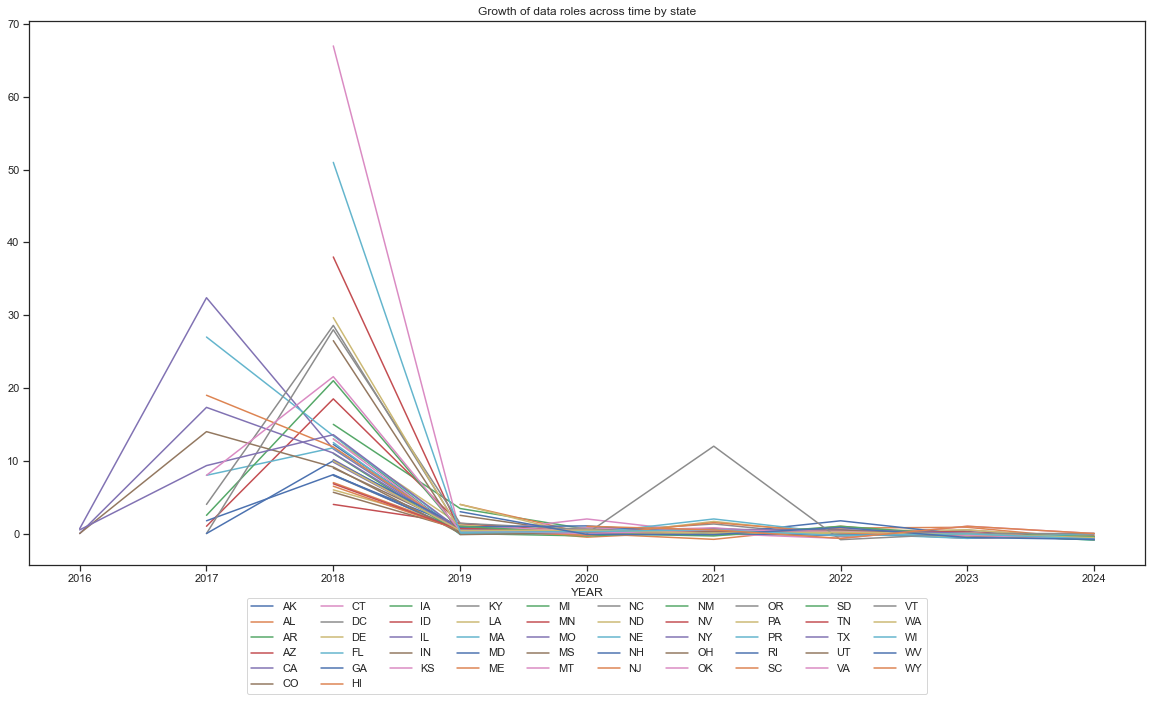

In [88]:
df_plt_growth = df_plt.loc[:, df_plt.columns!='YEAR'].pct_change() 
# df_plt_growth = df_plt_growth.drop(2013)
ax = df_plt_growth.plot.line(figsize=(20, 10), title="Growth of data roles across time by state")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

For YoY change in data roles, we see a drop in growth of data roles across all states in 2017, and no clear trend subsequently. However, there are also obvious spikes in growth for these roles in 2019 across some states, such as West Virginia, Arkansas and Delaware. In 2021, there is also an obvious splike in growth for Vermont.

In [ ]:
category = "STATE"

years = data_comb["YEAR"].unique()
df_state_agg = data_comb.copy()
df_state_agg["STATE_EMPLOYEE_SIZE"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_state_agg[df_state_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.5)
    all_S = list(df_temp[df_temp["size"] < median]["STATE"])
    df_state_agg['STATE_EMPLOYEE_SIZE'].mask(((df_state_agg["YEAR"] == year) & (df_state_agg["STATE"].isin(all_S))),'S', inplace=True)

category = "STATE_EMPLOYEE_SIZE"

df_plt = df_state_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_state_agg["STATE_EMPLOYEE_SIZE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by state, sorted according to employee size")

By further creating variable STATE_EMPLOYEE_SIZE that classifies states as L (large) and S (small) based on its number of data employees, we can see that the number of data roles for both of these states have generally increased from 2014 to 2022, then decreased in 2023. This trend is more prominent in states with a large number of data employees.

### 2d. Analysis of wage by state

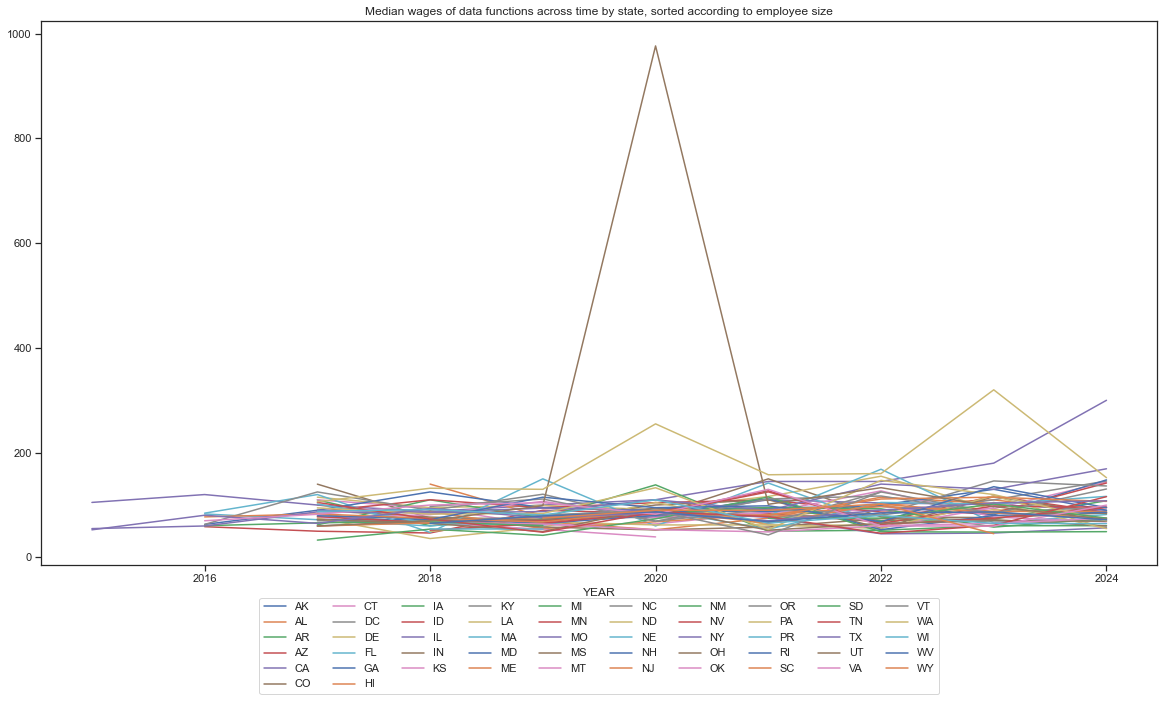

In [90]:
category = "STATE"
df_plt = data_comb[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.line(figsize=(20, 10), title="Median wages of data functions across time by state, sorted according to employee size")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

From this, the median wage across states generally follow an increasing trend across time.

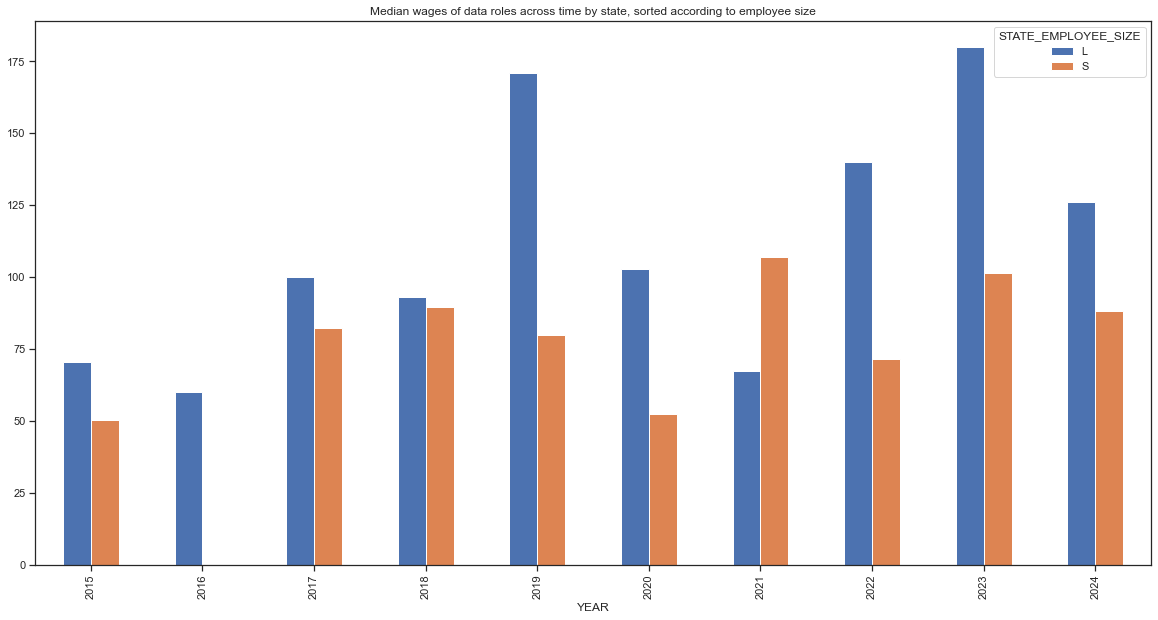

In [16]:
category = 'STATE_EMPLOYEE_SIZE'
df_plt = df_state_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by state, sorted according to employee size")

The median wages in states with a large number of data employees are generally higher than that of states with smaller numbers of data employee, with the exception of 2015 and 2023. In both of these type of states, median wages do not follow a clear trend and generally fluctuate over time. Additionally, in 2023, median wage hit an all time high in both of these type of states.

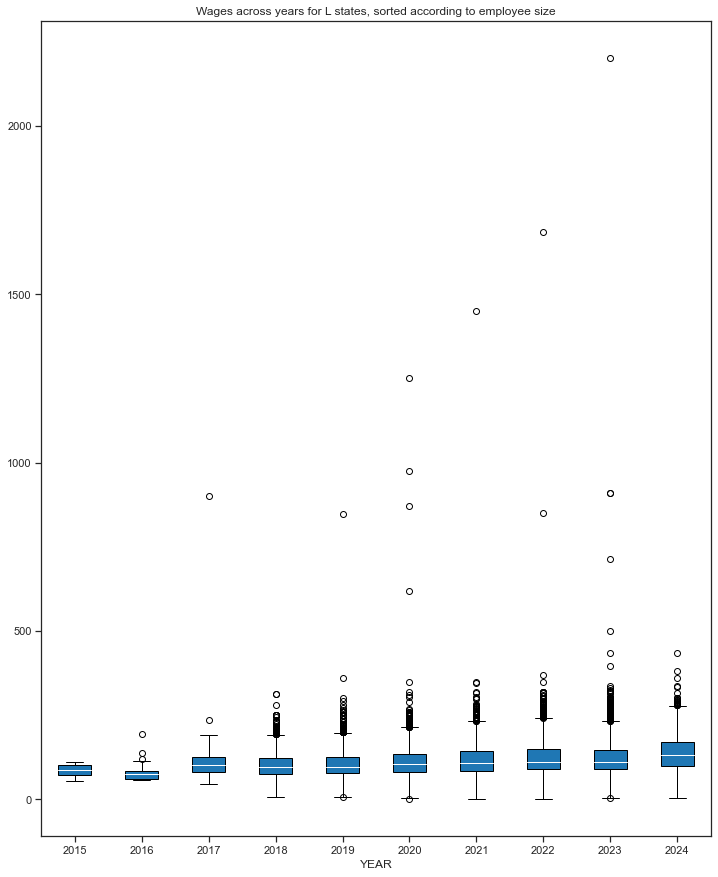

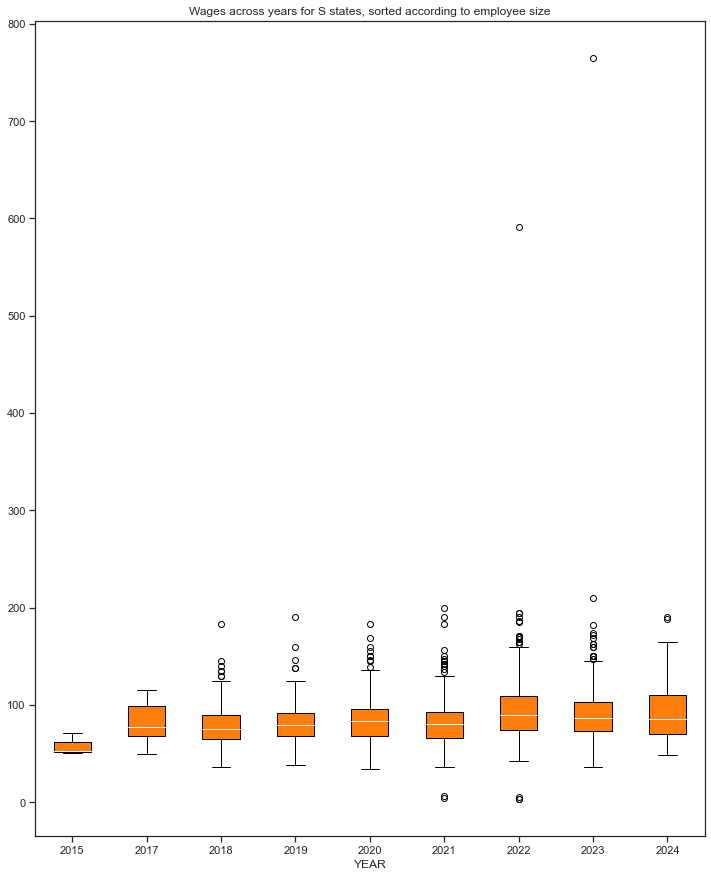

In [17]:
df_plt = df_state_agg[["YEAR", category, "y"]]

colors = ['#1f77b4','#ff7f0e']
for size, color in zip(df_plt[category].unique(), colors):
    df_filtered = df_plt[df_plt['STATE_EMPLOYEE_SIZE'] == size]
    df_year = df_filtered.groupby('YEAR')['y'].apply(list)

    fig, ax = plt.subplots(figsize=(12, 15))
    box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,
                     boxprops=dict(facecolor=color),
                     medianprops=dict(color='white'))
    ax.set_title(f'Wages across years for {size} states, sorted according to employee size')
    ax.set_xlabel('YEAR')
    #    ax.set_ylabel('y')
    plt.show()

For states with a large number of data employees, the median wage has generally increased slowly over the years. The wage distribution has roughly maintaine over the years, despite a large number of outliers earning significantly beyond the median wage. For states with a small number of data employees, the median wage has also generally increased along with a widening wage distribution, with exception of 2024. Currently, the wage distribution has decreased, with median wage skewing negative of the distribution.

### 2e. Analysis of job demand by employer

M    51243
L    40367
S     7229
Name: EMPLOYER_SIZE, dtype: int64


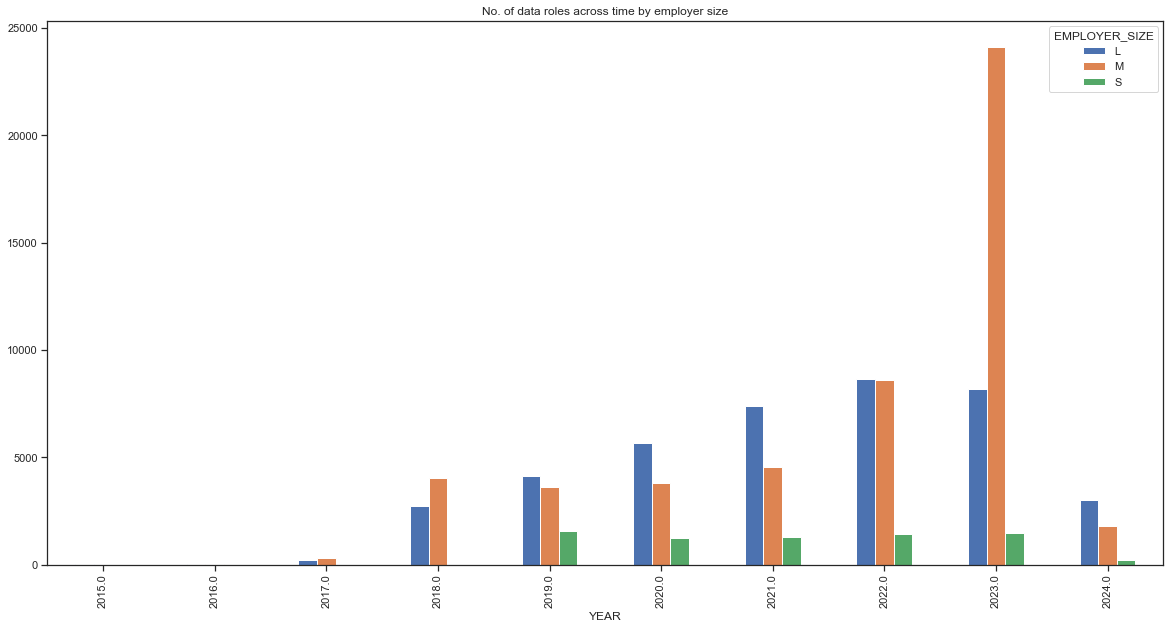

In [91]:
category = "EMPLOYER_SIZE"

df_plt = data_comb[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(data_comb["EMPLOYER_SIZE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by employer size")

By further creating variable EMPLOYER_SIZE that classifies employers as L (large) and S (small) based on its number of data employees, we can see that the number of data roles for both of these states have generally increased from 2014 to 2022, then decreased in 2023. This trend is more prominent in states with a large number of data employees.

### 2f. Analysis of wage by employer

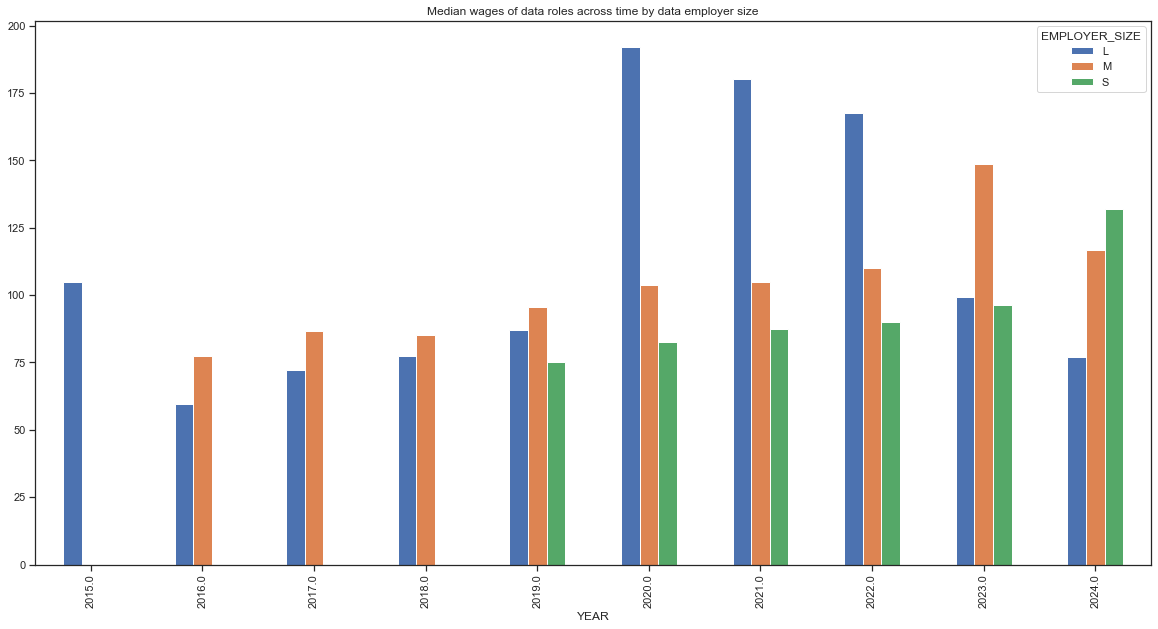

In [92]:
# get median wage of each job role for each year
df_plt = data_comb[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by data employer size")

The growth in median wages at large data employees outpaced that of small data employers, from 2021 to 2023, though not always higher when compared in absolute terms. While small data employees saw a drop in median wage in 2023, a similar drop was only observed for large data employees in 2024.

In [20]:
df_cleaned = df_type_agg.copy()
df_cleaned["STATE_EMPLOYEE_SIZE"] = df_state_agg["STATE_EMPLOYEE_SIZE"]
df_cleaned["EMPLOYER_SIZE"] = df_employer_agg["EMPLOYER_SIZE"]

In [93]:
X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(data_comb.dropna(subset=["y"]))


# 3. Baseline Model
Assuming that no preprocessing was done to any of the above features

In [94]:
categorical_features_one_hot = ['JOB TITLE', 'TYPE', 'EXP', 'employment_type',
                                'work_setting', 'LOCATION', 'EMPLOYER_SIZE', 
                                'work_models', 'EMPLOYER', 'STATE']

categorical_features_ordinal = []
numerical_features = ["YEAR","remote_ratio"]

clean_pipeline = get_pipeline_clean_encode_impute(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

In [95]:
baseline_lr = Pipeline([
  ('clean_pipeline', clean_pipeline),
  ('standard_scaler', StandardScaler()),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])
baseline_lr.fit(X_train, y_train)
pred = baseline_lr.predict(X_test)

score = mean_absolute_error(pred, y_test)
print('MAE: %.3f (%.3f)' % (score, np.std(pred)))


# n_scores = cross_val_score(baseline_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
# models_performance["Baseline"] = [abs(np.mean(n_scores)), np.std(n_scores)]
# # report performance
# print('MAE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MAE: 19.980 (20.625)


['STATE_WA', 'YEAR', 'LOCATION_US', 'EMPLOYER_FACEBOOK INC', 'TYPE_data analyst', 'EMPLOYER_META PLATFORMS INC', 'LOCATION_United States', 'TYPE_machine learning', 'EXP_Senior', 'STATE_CA']


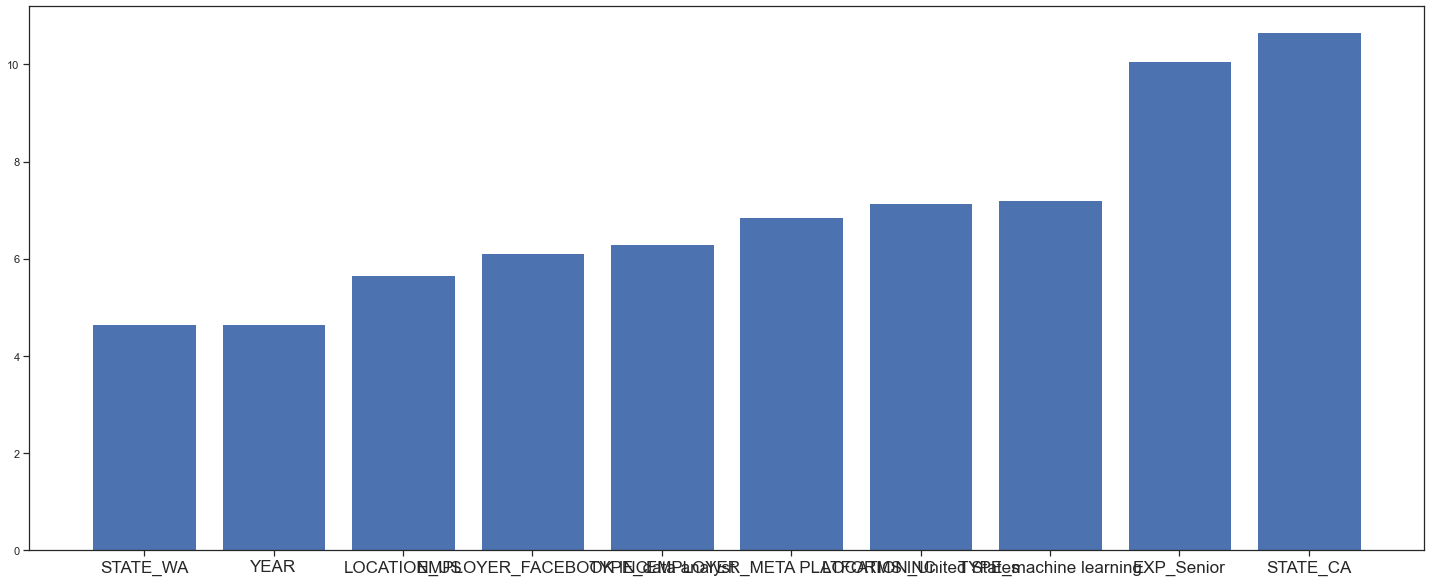

In [96]:
baseline_lr.fit(X_train, y_train)
X_train_cleaned = clean_pipeline.fit_transform(X_train)

# get importance
importance = np.abs(baseline_lr['lasso_regressor'].coef_)
features = list(X_train_cleaned.columns)

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(25,10))
plt.xticks(fontsize=17)

print(impt_features)
plt.bar(impt_features, impt_features_score)
plt.show()


## 3a. Decision Tree
We also attempt at using decision tree to help us with feature selection

In [99]:
tree_lr = Pipeline([
    ('clean_pipeline', clean_pipeline),
    ('standard_scaler', StandardScaler()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=5, random_state=RANDOM_STATE))
])

tree_lr.fit(X_train, y_train)
pred = tree_lr.predict(X_test)

score = mean_absolute_error(pred, y_test)
print('MAE: %.3f (%.3f)' % (score, np.std(pred)))

# n_scores = cross_val_score(tree_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
# models_performance["DecisionTreeRegressor"] = [abs(np.mean(n_scores)), np.std(n_scores)]
# # report performance
# print('MAE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MAE: 22.037 (23.631)


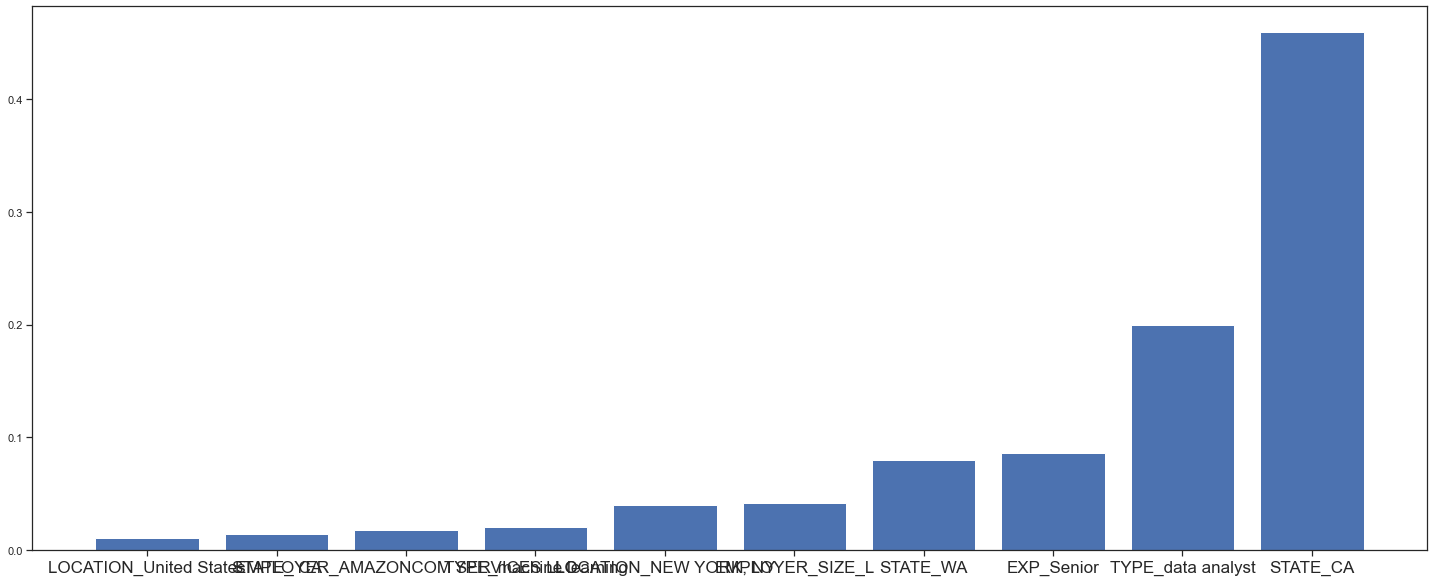

In [100]:
# get importance
tree_lr.fit(X_train, y_train)
X_train_cleaned = clean_pipeline.fit_transform(X_train)

importance = tree_lr['DecisionTreeRegressor'].feature_importances_
features = list(X_train_cleaned.columns)

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(25,10))
plt.xticks(fontsize=17)

plt.bar(impt_features, impt_features_score)
plt.show()

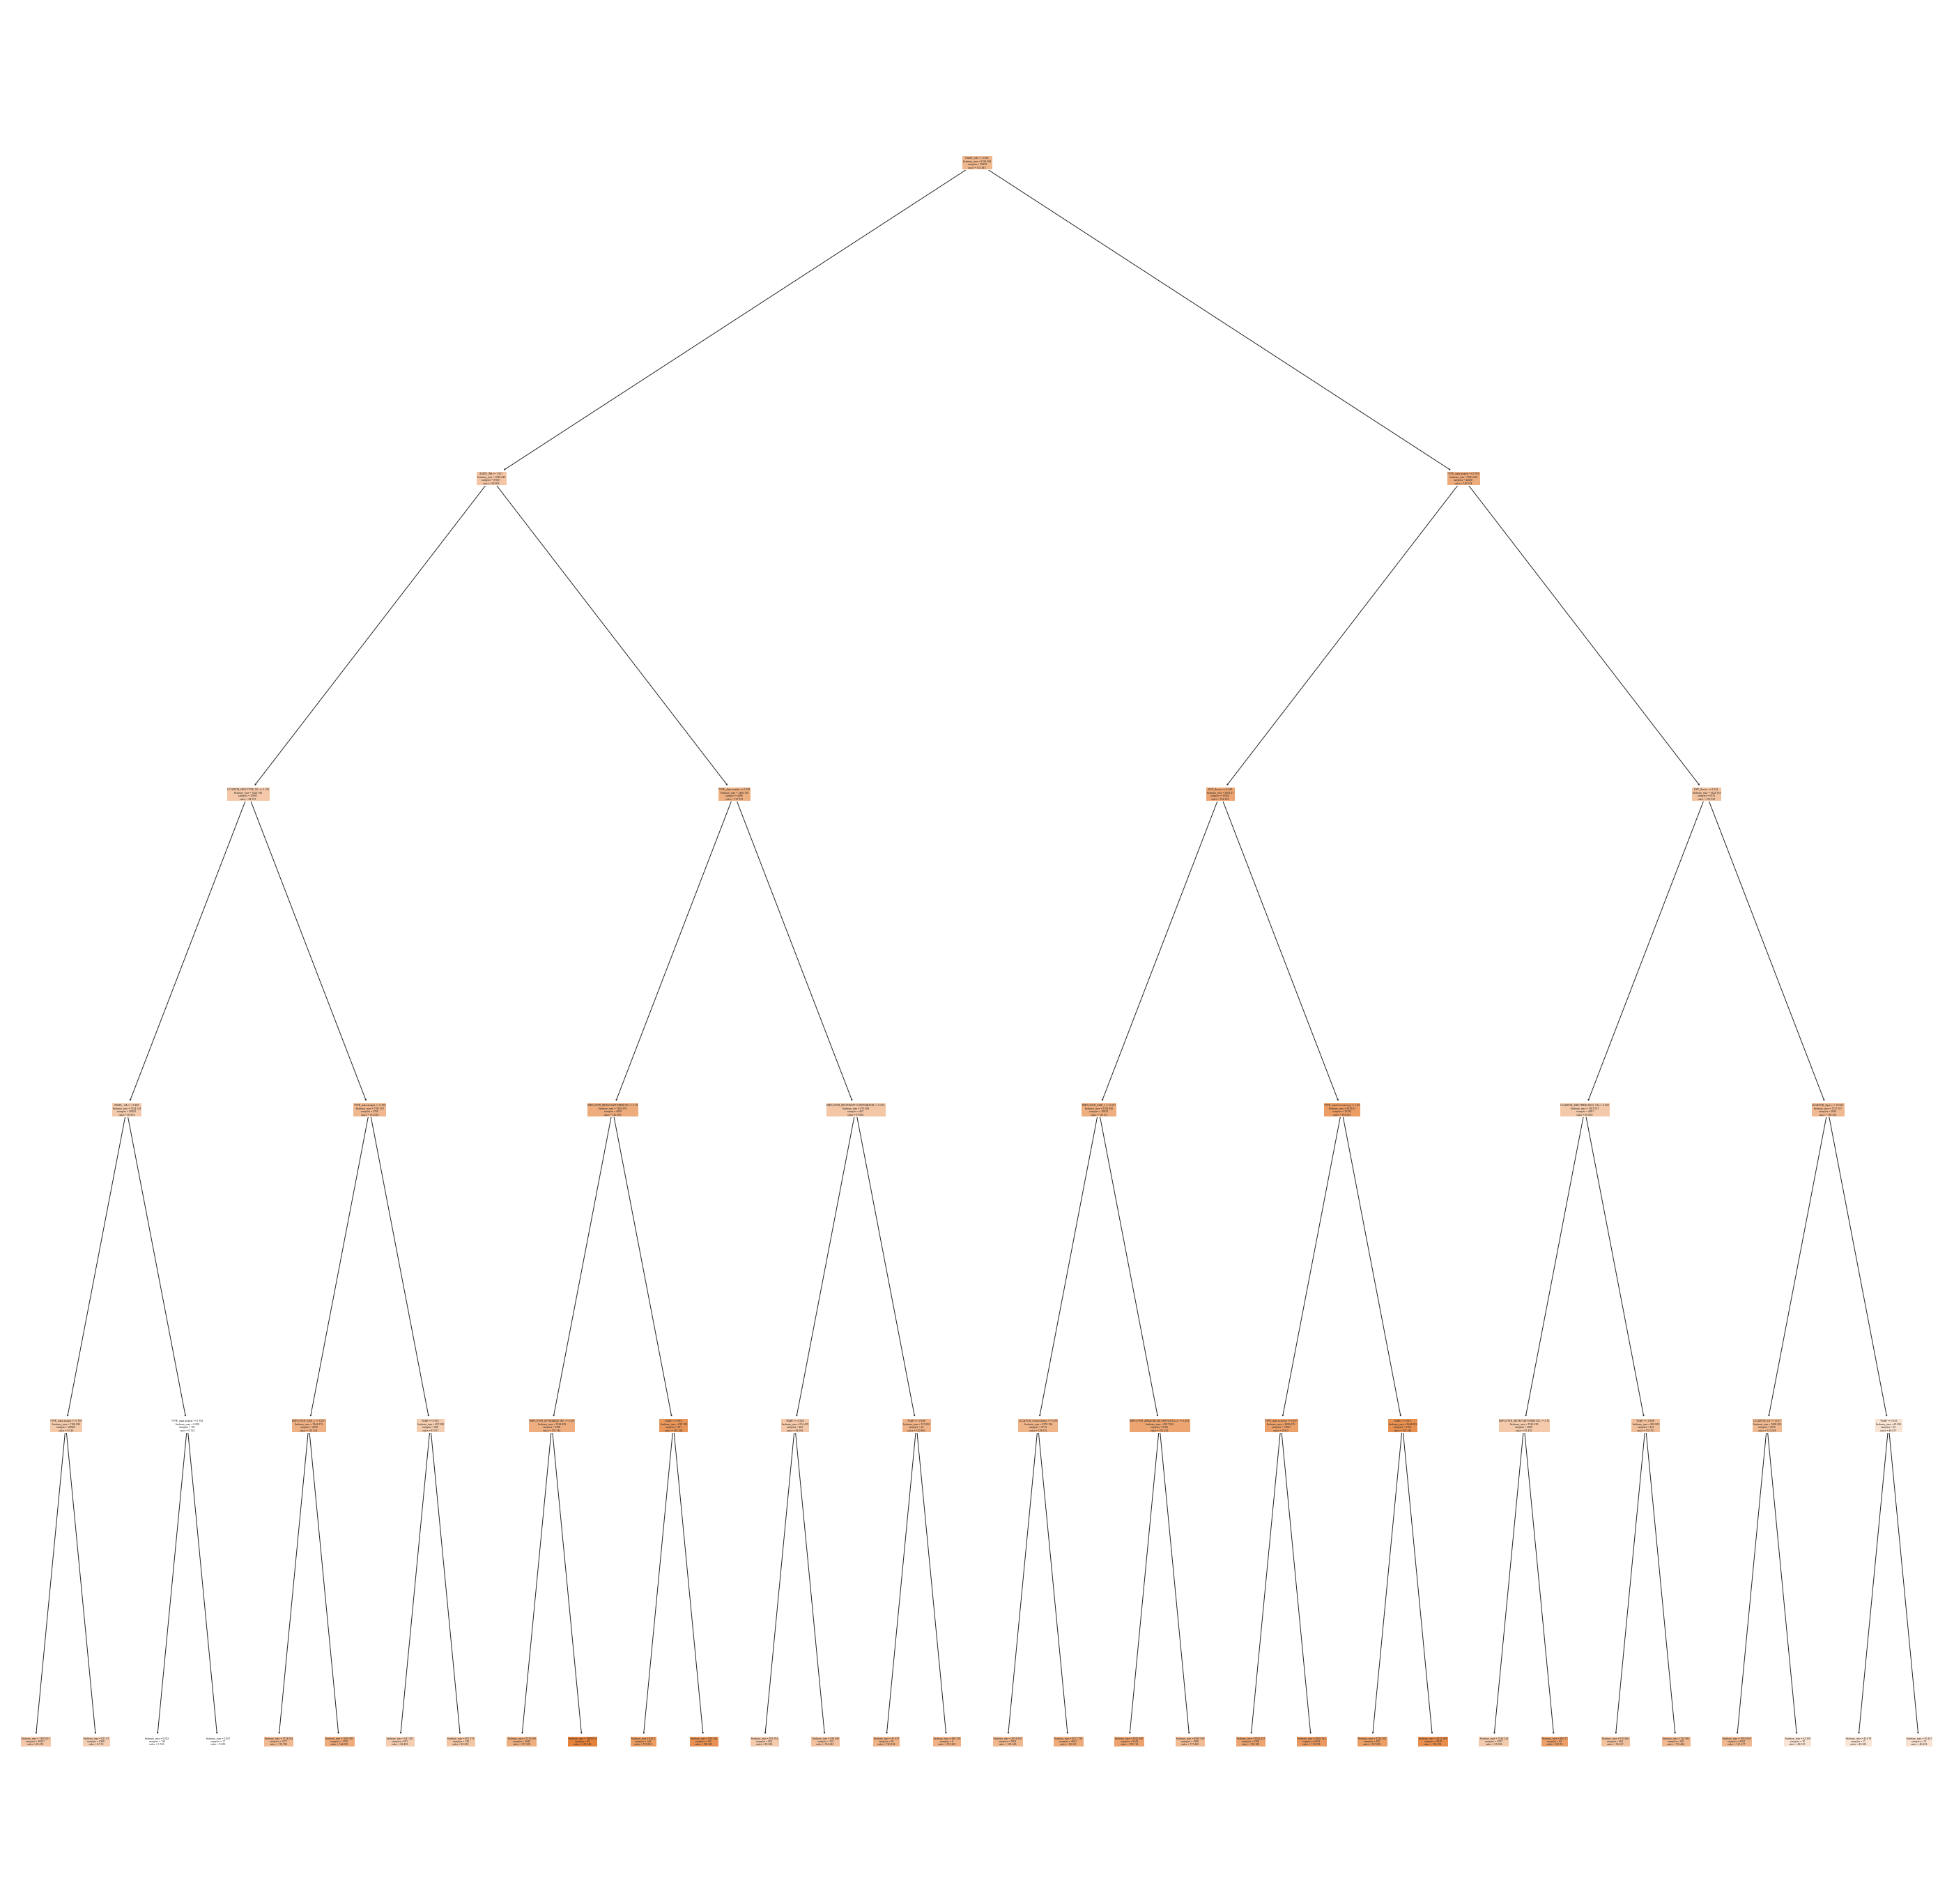

In [101]:
tree_lr.fit(X_train, y_train)

fig = plt.figure(figsize=(50,50))
_ = plot_tree(tree_lr['DecisionTreeRegressor'], 
                   feature_names=X_train_cleaned.columns,  
                   class_names=['0','1'],
                   filled=True)